## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single hashtag
* "➋" represents a single URL
* "➌" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.externals import joblib
from nltk.corpus import stopwords
from random import choice
from string import punctuation

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
hashtags_pattern = r'(\#[a-zA-Z0-9]+)'

In [4]:
urls_pattern = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))'


In [5]:
at_mentions_pattern = r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)'

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files

In [10]:
subtweets_data = [t for t in json.load(open("../data/other_data/subtweets.json")) 
                  if t["tweet_data"]["user"]["lang"] == "en" 
                  and t["reply"]["user"]["lang"] == "en"]

In [11]:
non_subtweets_data = [t for t in json.load(open("../data/other_data/non_subtweets.json")) 
                      if t["tweet_data"]["user"]["lang"] == "en" 
                      and t["reply"]["user"]["lang"] == "en"]

#### Only use tweets with at least 50% English words
#### Also, make the mentions of usernames, URLs, and hashtags generic

In [12]:
%%time
subtweets_data = [(re.sub(hashtags_pattern, 
                          "➊", 
                          re.sub(urls_pattern, 
                                 "➋", 
                                 re.sub(at_mentions_pattern, 
                                        "➌", 
                                        t["tweet_data"]["full_text"])))
                   .replace("\u2018", "'")
                   .replace("\u2019", "'")
                   .replace("&quot;", "\"")
                   .replace("&amp;", "&")
                   .replace("&gt;", ">")
                   .replace("&lt;", "<"))
                  for t in subtweets_data]

CPU times: user 268 ms, sys: 16.6 ms, total: 284 ms
Wall time: 297 ms


In [13]:
new_subtweets_data = []
for tweet in subtweets_data:
    tokens = tokenizer.tokenize(tweet)
    english_tokens = [english_dict.check(token) for token in tokens]
    percent_english_words = sum(english_tokens)/len(english_tokens)
    if percent_english_words >= 0.5:
        new_subtweets_data.append(tweet)

In [14]:
%%time
non_subtweets_data = [(re.sub(hashtags_pattern, 
                              "➊", 
                              re.sub(urls_pattern, 
                                     "➋", 
                                     re.sub(at_mentions_pattern, 
                                            "➌", 
                                            t["tweet_data"]["full_text"])))
                       .replace("\u2018", "'")
                       .replace("\u2019", "'")
                       .replace("&quot;", "\"")
                       .replace("&amp;", "&")
                       .replace("&gt;", ">")
                       .replace("&lt;", "<"))
                      for t in non_subtweets_data]

CPU times: user 418 ms, sys: 31.7 ms, total: 450 ms
Wall time: 452 ms


In [15]:
new_non_subtweets_data = []
for tweet in non_subtweets_data:
    tokens = tokenizer.tokenize(tweet)
    english_tokens = [english_dict.check(token) for token in tokens]
    percent_english_words = sum(english_tokens)/len(english_tokens)
    if percent_english_words >= 0.5:
        new_non_subtweets_data.append(tweet)

#### Show examples

In [16]:
print("Subtweets dataset example:")
print(choice(new_subtweets_data))

Subtweets dataset example:
My feelings are all over the place. We're supposed to be engaged and both of us being busy dosen't help. I guess the babies just complete our little family and we'll have more time with each other when they come.😔


In [17]:
print("Non-subtweets dataset example:")
print(choice(new_non_subtweets_data))

Non-subtweets dataset example:
➌ Hi there! I wasn't able to get through by phone, so I thought I'd ask my MtG question here: Are you taking preorders for booster boxes of Dominaria? If so, how much are they and can they be collected at the prerelease event?
Thank you!


#### Find the length of the smaller dataset

In [18]:
smallest_length = len(min([new_subtweets_data, new_non_subtweets_data], key=len))

#### Cut both down to be the same length

In [19]:
subtweets_data = new_subtweets_data[:smallest_length]

In [20]:
non_subtweets_data = new_non_subtweets_data[:smallest_length]

In [21]:
print("Smallest dataset length: {}".format(len(non_subtweets_data)))

Smallest dataset length: 7837


#### Prepare data for training

In [22]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [23]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [24]:
training_data = subtweets_data + non_subtweets_data

#### Create custom stop words to include generic usernames, URLs, and hashtags, as well as common English first names

In [25]:
names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])

In [26]:
generic_tokens = {"➊", "➋", "➌"}

In [27]:
stop_words = text.ENGLISH_STOP_WORDS | names_lower | generic_tokens

#### Build the pipeline

In [28]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words=stop_words)),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [29]:
text_training_data = np.array([row[0] for row in training_data])

In [30]:
class_training_data = np.array([row[1] for row in training_data])

In [31]:
num_folds=10

In [32]:
kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)

In [33]:
%%time
cnf_matrix = np.zeros((2, 2), dtype=int)
for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):
    
    text_train, text_test = text_training_data[train_index], text_training_data[test_index]
    class_train, class_test = class_training_data[train_index], class_training_data[test_index]
    
    sentiment_pipeline.fit(text_train, class_train)
    predictions = sentiment_pipeline.predict(text_test)
        
    cnf_matrix += confusion_matrix(class_test, predictions)
    
    print("Iteration {}".format(i+1))
    print(classification_report(class_test, predictions, digits=3))
    print("null accuracy: {:.3f}\n".format(max(pd.value_counts(pd.Series(class_test)))/float(len(class_test))))
    print("="*53)

Iteration 1
              precision    recall  f1-score   support

non-subtweet      0.732     0.644     0.685       793
    subtweet      0.676     0.759     0.715       775

 avg / total      0.704     0.701     0.700      1568

null accuracy: 0.506

Iteration 2
              precision    recall  f1-score   support

non-subtweet      0.688     0.631     0.658       789
    subtweet      0.655     0.710     0.681       779

 avg / total      0.672     0.670     0.670      1568

null accuracy: 0.503

Iteration 3
              precision    recall  f1-score   support

non-subtweet      0.703     0.685     0.694       769
    subtweet      0.704     0.721     0.712       799

 avg / total      0.703     0.703     0.703      1568

null accuracy: 0.510

Iteration 4
              precision    recall  f1-score   support

non-subtweet      0.731     0.639     0.682       801
    subtweet      0.667     0.755     0.708       767

 avg / total      0.700     0.696     0.695      1568

null accur

#### See the most informative features

In [34]:
def most_informative_features(pipeline, n=50):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Weight": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Weight": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [35]:
most_informative_features_all = most_informative_features(sentiment_pipeline)

In [36]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [37]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [38]:
most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                            lsuffix=" (Non-subtweet)", 
                                            rsuffix=" (Subtweet)")

,Feature (Non-subtweet),Weight (Non-subtweet),Feature (Subtweet),Weight (Subtweet)
0,! ! &,-12.6640,.,-7.5326
1,! ! (,-12.6640,",",-7.9221
2,! ! ),-12.6640,people,-8.3929
3,! ! .,-12.6640,?,-8.4622
4,! ! 100,-12.6640,don't,-8.5613
5,! ! 15,-12.6640,like,-8.5917
6,! ! 3,-12.6640,"""",-8.6097
7,! ! 5,-12.6640,just,-8.6781
8,! ! 8am,-12.6640,i'm,-8.6996
9,! ! :),-12.6640,!,-8.9060


#### Define function for visualizing confusion matrices

In [39]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted Label")

#### Show the matrices

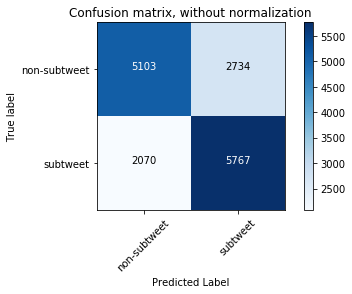

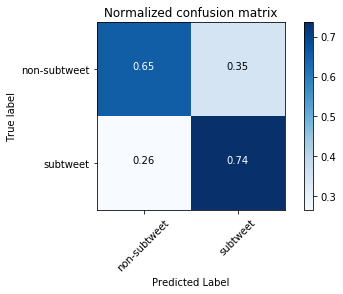

In [40]:
class_names = ["non-subtweet", "subtweet"]

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Update matplotlib style

In [41]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [42]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [43]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [44]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [45]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Remove usernames, URLs, and hashtags

In [46]:
test_tweets_df["Tweet"] = test_tweets_df["Tweet"].str.replace(hashtags_pattern, "➊")

In [47]:
test_tweets_df["Tweet"] = test_tweets_df["Tweet"].str.replace(urls_pattern, "➋")

In [48]:
test_tweets_df["Tweet"] = test_tweets_df["Tweet"].str.replace(at_mentions_pattern, "➌")

#### Print the tests

In [49]:
tests_dataframe(test_tweets_df, text_column="Tweet", 
                sentiment_column="Sentiment").drop(["sentiment_score", 
                                                    "subtweet_negative_probability"], axis=1)

,subtweet_positive_probability,tweet
0,0.7802,Some people don't know their place.
1,0.7730,Isn't it funny how some people don't know their place?
2,0.7179,How come you people act like this?
3,0.6903,You're such a nerd.
4,0.5781,"I love Noah, he's so cool."
10,0.4981,➋
5,0.4625,Who the heck is Noah?
6,0.4487,This is a ➌ subtweet. Go check out ➋.
7,0.4425,This is a subtweet.
8,0.2996,Hey ➌!


#### Tests on friends' tweets

#### Aaron

In [50]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

#### Remove usernames, URLs, and hashtags

In [51]:
aaron_df["Text"] = aaron_df["Text"].str.replace(hashtags_pattern, "➊")

In [52]:
aaron_df["Text"] = aaron_df["Text"].str.replace(urls_pattern, "➋")

In [53]:
aaron_df["Text"] = aaron_df["Text"].str.replace(at_mentions_pattern, "➌")

In [54]:
aaron_df = tests_dataframe(aaron_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

In [55]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [56]:
aaron_df.head(10)

,subtweet_positive_probability,tweet
2092,0.8578,I hate when people overuse emojis
2137,0.8442,Also you don't need to resort to social media 24/7 to complain about your very privileged life ¯\_(ツ)_/¯
2151,0.8366,When I try to be supportive and caring I get ignored and then I'm told I'm not being supportive or caring ¯\_(ツ)_/¯
2134,0.8177,What he doesn't know (unless he stalks my twitter which I know he does) is that I have fake accounts following all his social media
181,0.8143,"I often obsess when texting older people if they will think less of me for saying ""LOL"" so I say ""haha"" instead but my mom just texting me ""LOL"" so maybe I've been overthinking this?"
1510,0.8076,If you don't have tweet notifications turned on for me are we really friends
658,0.8062,I wonder how many animal social media accounts I follow across every platform
2076,0.8027,I still don't understand why my brother feels a need to literally narrate his life on Twitter. Nobody cares when you go to sleep or wake up
1519,0.8013,Is it weird how my mind designates which social media specific content belongs on? Like this tweet wouldn't make sense to me on facebook
2319,0.8005,Sometimes I wonder if people don't realize the 140 character limit and try to type a really long message and end up having it get cut off at


In [57]:
aaron_df_for_plotting = aaron_df.drop(["tweet"], axis=1)

#### Julia

In [58]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

#### Remove usernames, URLs, and hashtags

In [59]:
julia_df["Text"] = julia_df["Text"].str.replace(hashtags_pattern, "➊")

In [60]:
julia_df["Text"] = julia_df["Text"].str.replace(urls_pattern, "➋")

In [61]:
julia_df["Text"] = julia_df["Text"].str.replace(at_mentions_pattern, "➌")

In [62]:
julia_df = tests_dataframe(julia_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

In [63]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [64]:
julia_df.head(10)

,subtweet_positive_probability,tweet
3197,0.8674,unpopular twitter opinion I don't like christine sudoku and elijah whatever and I don't think they're funny
3613,0.8566,don't follow bachelor contestants u liked on insta bc it will just make u hate them for being annoying and unoriginal ➊
2325,0.8399,I love seeing people I knew from hs at the gym! and by that I mean don't talk to me don't even look at me
1555,0.8317,tbt to when ➌ are real trash out of the garbage
3913,0.8153,tfw ur anxiety kills ur appetite but you can't do anything done bc ur still hungry so u just get more anxiety ➊
2235,0.8152,david mitchell said the world is full of people who want to make people who don't want to dance dance....
1450,0.8129,"between this is just to say and sophia the robot memes, twitter has been fucking On recently"
3859,0.8108,I don't really tmi about volleyball on twitter but I wish I could bc I could vent for hours about how this sport makes me feel lyk trash
2970,0.8066,"funny how some people have suddenly become serious """"academics"""" and think they're amazingly intelligent now....try no bitch u fake as fuck"
3348,0.8026,one critique I have of westworld: there are too many boring white guys with beards and it's hard to tell them apart


In [65]:
julia_df_for_plotting = julia_df.drop(["tweet"], axis=1)

#### Noah

In [66]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

#### Remove usernames, URLs, and hashtags

In [67]:
noah_df["Text"] = noah_df["Text"].str.replace(hashtags_pattern, "➊")

In [68]:
noah_df["Text"] = noah_df["Text"].str.replace(urls_pattern, "➋")

In [69]:
noah_df["Text"] = noah_df["Text"].str.replace(at_mentions_pattern, "➌")

In [70]:
noah_df = tests_dataframe(noah_df, text_column="Text", 
                          sentiment_column="Sentiment").drop(["sentiment_score", 
                                                              "subtweet_negative_probability"], axis=1)

In [71]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [72]:
noah_df.head(10)

,subtweet_positive_probability,tweet
2022,0.8972,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be
1689,0.8490,linkedin is better than twitter.\ndon't @ me.
1716,0.8412,If you don't make your meatloaf with ketchup don't bother talking to me
2027,0.8372,IF U CALL URSELF A WEEB BUT DONT HAVE ANIME PROF PICS ON ALL SOCIAL MEDIA\n DELETE UR ACCOUNTS
1760,0.8172,don't ever talk to me or my hamartia ever again
340,0.8130,Twitter changed the way bots download tweets and now my friends’ twitter bots can’t be updated unless they give me sensitive information
291,0.8129,"if you've still got tweet notifications on for me, I'm sorry, this is a subtweet"
2523,0.8090,Instead of posting several vague tweets revolving around my issues of self-worth I'll just ask this: Who decides how good a friend I am?
1797,0.8083,don't @ ➋
1242,0.8020,"stupid pet peeve of the evening:\nsaying ""greater than"" aloud 5 times sounds stupid\nso why type >>>>>"


In [73]:
noah_df_for_plotting = noah_df.drop(["tweet"], axis=1)

#### Rename the columns for later

In [74]:
aaron_df_for_plotting_together = aaron_df_for_plotting.rename(columns={"subtweet_positive_probability": "Aaron"})

In [75]:
julia_df_for_plotting_together = julia_df_for_plotting.rename(columns={"subtweet_positive_probability": "Julia"})

In [76]:
noah_df_for_plotting_together = noah_df_for_plotting.rename(columns={"subtweet_positive_probability": "Noah"})

#### Prepare statistics on friends' tweets

In [77]:
friends_df = pd.concat([aaron_df_for_plotting_together, 
                        julia_df_for_plotting_together, 
                        noah_df_for_plotting_together], ignore_index=True)

In [78]:
friends_df.describe()

,Aaron,Julia,Noah
count,2640.0000,4356.0000,2814.0000
mean,0.5069,0.5162,0.5063
std,0.1147,0.1014,0.1078
min,0.0953,0.1522,0.1506
25%,0.4295,0.4476,0.4326
50%,0.5027,0.5164,0.5017
75%,0.5837,0.5818,0.5736
max,0.8578,0.8674,0.8972


In [79]:
aaron_mean = friends_df.describe().Aaron[1]
aaron_std = friends_df.describe().Aaron[2]

julia_mean = friends_df.describe().Julia[1]
julia_std = friends_df.describe().Julia[2]

noah_mean = friends_df.describe().Noah[1]
noah_std = friends_df.describe().Noah[2]

#### Plot all the histograms

/Users/Noah/anaconda/envs/work/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


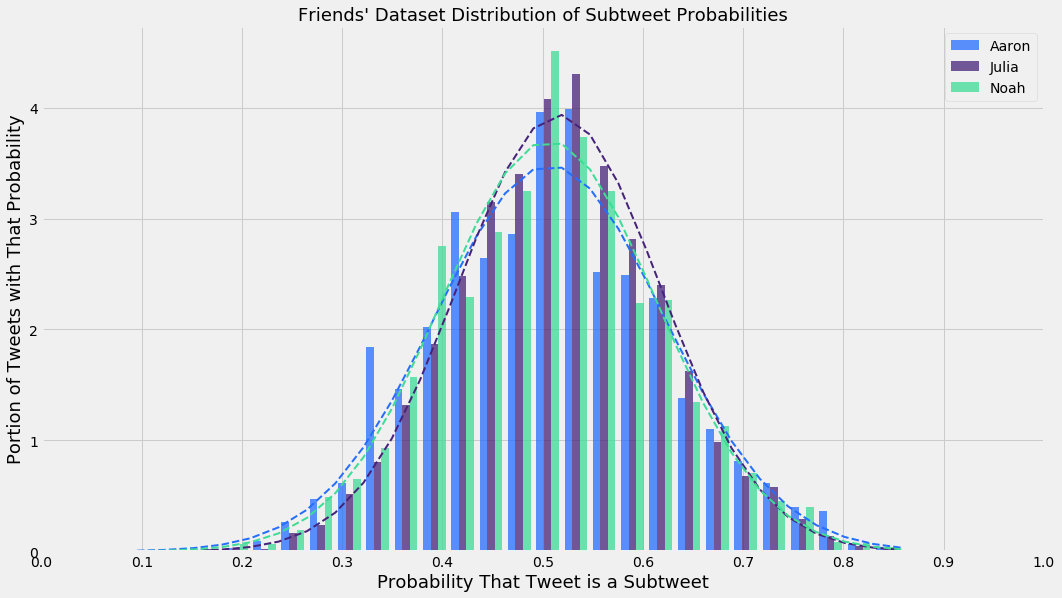

CPU times: user 617 ms, sys: 40.7 ms, total: 658 ms
Wall time: 649 ms


In [80]:
%%time
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist([aaron_df_for_plotting.subtweet_positive_probability, 
                            julia_df_for_plotting.subtweet_positive_probability, 
                            noah_df_for_plotting.subtweet_positive_probability], 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["Aaron", "Julia", "Noah"],
                           alpha=0.75)

aaron_line = scipy.stats.norm.pdf(bins, aaron_mean, aaron_std)
ax.plot(bins, aaron_line, "--", color="#256EFF", linewidth=2)

julia_line = scipy.stats.norm.pdf(bins, julia_mean, julia_std)
ax.plot(bins, julia_line, "--", color="#46237A", linewidth=2)

noah_line = scipy.stats.norm.pdf(bins, noah_mean, noah_std)
ax.plot(bins, noah_line, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Friends' Dataset Distribution of Subtweet Probabilities", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Portion of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [81]:
training_data = [" ".join([token for token in tokenizer.tokenize(pair[0]) if "@" not in token]) 
                 for pair in training_data]

#### Lengths (Less than or equal to 280 characters and greater than or equal to 5 characters)

In [82]:
length_data = [len(tweet) for tweet in training_data]

In [83]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [84]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [85]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [86]:
length_data = length_data_for_stats.Length.tolist()

#### Top 10 longest tweets

In [87]:
length_data_for_stats.sort_values(by="Length", ascending=False).head(10)

,Length,Tweet
14329,303,"from 10/18 / 15 when he 1st played hurt & began noticeably throwing w poor mechanics thru end of his injured 2016 yr , luck's stats were as good as his healthiest / best 2013-2014 yrs : - injured : 61 % comp , 7.4 ypa , 93 rtg , 41:18 td : int - healthy : 61 % comp , 7.2 ypa , 92 rtg , 63:25 td : int ➋"
4476,302,"in situations of power imbalance , wealth inequality , unequal access to ... everything-can ' we ' drop the ' we ' - because it really means you not me . when . you . pretend . that . we . all . share . same . interests . you . are . helping . the . most . powerful . oppress . the . least . powerful ."
8001,300,"hotel elevator earlier today : i get in , a young man and a young woman already in the car . me : "" good morning , both . "" woman : "" good morning . "" man , clearly writhing , not wanting to say anything but caught in a vortex due to the young woman's response . ten seconds later : "" ... morning . """
15228,299,""" it is a key agreement that shapes today's globalisation "" - frau merkel on the paris ' agreement ' . climatefraud-a contrived tool of the deadly eu / un-centric marxist-globalist / islamist alliance , to wealth transfer & to create such energy poverty , that sovereignwesterndemocracy implodes . ➋"
14724,299,"pentagon : master sergeant jonathan j . dunbar , assigned to headquarters , u . s . army special operations command , fort bragg , n . c . , was kia mar . 30 , while deployed in support of operation inherent resolve . dunbar died from wounds received during combat operations near manbij , syria . ➋"
6017,299,"person : * criticizes my writing * me : yup , they're right , 100 percent , spot on , very valid , absolutely agree person : * compliments my writing * me : ? ? ? did they read something else ? ? ? are they lying ? ? ? are they drunk ? ? ? i don't know what to do with this ? please just insult me ?"
8702,298,i've fallen into a rabbit hole of goals from that 2016 run . faves : 1 ) crosby's goal against raanta in rd . 1 . 2 ) cullen's goal in ny . third period . tie game . 3 ) fehr's goal in game 2 vs . washington . 4 ) rust's breakaway in game 6 vs . tampa . 5 ) fehr's game 5 insurance goal vs . sj . ➋
5265,296,"me : "" we can't deviate from the clinical policies the client's medical team chose "" coworker : "" well we'll ask the cto "" m : "" okay but he's in agreement too "" c : "" i don't want to talk to you . our medical licenses are on the line "" m : "" no ... they aren't . you didn't choose the policies """
8607,296,"the first-time event , bucky's yard sale , is april 12 and 13 from 9am - 2pm at etsu in the quad . donations of clothing , shoes accessories , and other cool things are needed ! drop-off bins are in the cpa , outside of sorc a in the culp , and in centennial , governors , stone , and clement . ➋"
9006,296,"➊ campaign ideas i can't get out of my head : 💠 gothic monster hunting ( e . g . krevborna , ravenloft , solomon kane ) 💠 aetherpunk intrigue ( e . g . kaladesh , lantan , eberron ) 💠 megadungeon exploration ( e . g . doomvault , rappan athuk ) merging them would not work well . need moar time ."


#### Top 10 shortest tweets

In [88]:
length_data_for_stats.sort_values(by="Length", ascending=True).head(10)

,Length,Tweet
7699,1,a
2038,2,ha
5896,2,uh
3473,2,no
3785,3,ugh
6676,3,i -
4596,3,die
9177,4,go ➋
636,4,us ➋
648,4,oh ➋


#### Tweet length statistics

In [89]:
length_data_for_stats.describe()

,Length
count,15674.0000
mean,109.5542
std,75.5204
min,1.0000
25%,50.0000
50%,89.0000
75%,154.0000
max,303.0000


#### Punctuation

In [90]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [91]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 10 most punctuated tweets

In [92]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head(10)

,Punctuation,Tweet
8957,10,"going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting , deciding i would like to try them , then being told "" i'm sorry sir , that's actually not available ... "" [ then why the # $ % is it on your menuuu - - ]"
13365,9,"billboard hot 100 : ➊ ( - 3 ) tell me you love me , ➌ [ 19 weeks ] . * peak : ➊ *"
11066,9,"not every aspect worked , but overall had a lot of fun at ➊ . and also ( minor spoiler-ish thingy below ) ... … maybe the best "" single use of the f word in a pg - 13 movie "" ever ? ( didn't hurt that it was connected to a great love of mine ! )"
11845,9,"tucker carlson tonight & tfw you're asking about america but you're scolded it's really about israel ... tucker : "" what is the american national security interest ... in syria ? "" sen . wicker ( r ): "" well , if you care about israel ... "" that was the exact question & answer shocking ➋"
11718,9,"self-employed people : have you ever turned to social media to call out a client who is many weeks / months delinquent on a payment ? ( obviously , you're probably burning a bridge with that move , but if they don't pay ... )"
909,9,"twitter user : "" if you're [ oppressed identity / status / role ] , no need to read this ; if you're [ privileged identity / status / role ] , read it "" the parts of my brain responsible for assuring my physical & emotional safety as a brainwashing survivor with 3000 diseases : ➋"
6725,9,"4 - yo : daddeee ! ? let's play ! me : ok , baby . 4yo : you play w / her . put a dress on her daddeee . me : ok . * puts doll in dollhouse * 4yo : she doesn't go there ! !"
13933,9,"feds had one chance to search cohen's places ! since he , alone & w / trump , has been busy w / so much possibly criminal activity , searches covered the whole enchilada : bank fraud , tax crimes , $ laundering & 2016 election-related crimes , including payoffs that could be fec violations . ➋"
13817,8,print orders are available in my etsy store : ➋ ( * ´ ∀ ` * ) i am very proud of these prints and i'm very happy with their quality ! ! i hope you like them . this is a great way to support my works ( ｡ ･ ω ･ ｡ ) ﾉ ♡ rt and shares are always appreciated 💕 ➋
14623,8,"park jimin fancafe 01.04 . 2018 { 12:30 am kst } i left the dorm , hoseok will be alone in the room , i don't know what is army anymore you're all just from the past bye don't come to me when u see me in the street & say jimin because ima punch u in the face ➊_we_are_beardtan"


#### Tweets punctuation statistics

In [93]:
punctuation_data_for_stats.describe()

,Punctuation
count,15674.0000
mean,1.8610
std,1.5408
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,10.0000


#### Stop words

In [94]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [95]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 10 tweets with most stop words

In [96]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head(10)

,Stop words,Tweet
0,8,"i don't yet have adequate words to do so , but someday i wanna write about the beautiful dance which happens in google docs between a writer & a good editor working simultaneously towards a deadline . when it's working , it's a beautiful dance — though no one really sees it ."
9062,8,➌ too fine .. ima need him to have a show in a city near me 😩
9033,8,"how is this still a "" phase "" if i'm voluntarily putting myself through a second , more intense puberty ? ? 🤔"
9035,8,the role of dag rod rosenstein will be an oscar winner in the future film about the trump presidency . i'd like the story of the first few months to be told through the eyes of the bewildered sean spicer .
9038,8,"done watching ' hacksaw ridge ' . if there's one thing i learned from that movie , it is simply , have faith in god ."
9039,8,i feel people who can't celebrate or at the very least respect cardi b's success have never watched the grind from the ground up . they can't understand that her work ethic has gotten her where she is now . you don't have to stand for what's she's about but she's worked for it
9040,8,icymi : dolphins need to improve their 2nd round draft picks : ➋
9041,8,another republican who wants us back in syria but doesn't want to vote for it . does the country support america going in alone ? ➋
9043,8,you ever just have your phone in your hand and then you hand just decides it doesn't want to hold it anymore and throws it in the ground .
9044,8,footage from the night of kenneka jenkins passing . please pass this on these two men were working the night she passed and were seen following her in the hallway ! ! ! police need to ask them what was in this bag . ➌ ➋


#### Top 10 tweets with fewest stop words

In [97]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head(10)

,Stop words,Tweet
8290,0,24 ➋
9100,0,... ➋
958,0,luv u
14086,0,➊ well ...
3785,0,ugh
3632,0,... ➋
11925,0,fuck ➋
3455,0,fuck ... ➋
1662,0,uh ➋
5896,0,uh


#### Tweets stop words statistics

In [98]:
stop_words_data_for_stats.describe()

,Stop words
count,15674.0000
mean,7.1504
std,1.3123
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words (at least 2)

In [99]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [100]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [101]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [102]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 10 tweets with most unique words

In [103]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head(10)

,Tweet,Unique words
13936,"give away ! the rules are really easy , all you have to do is : 1 . must be following me ( i check ) 2 . rt and fav this tweet 3 . tag your mutuals / anyone 4 . only 1 winner ! 5 . i ship worldwide ;) it ends in 8th may 2018 or when this tweet hit 2k rt and like ! good luck ! ❤ ➋",60
4881,"got into a tepid back nd forth w / a uknowwhoaj + columnist bc i said they steal their "" hot takes "" from blk twitter & alike . wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is post colonial memes for oriental minded t -",57
7013,"crazy how wrong u can be about someone . a girl i graduated w / was always doing drugs & got pregnant at 16 . i assumed she'd end up being a loser but it turn out she now has 4 beautiful kids & is making over $ 4,500 / month just off of child support payments from the 3 different dads",57
11542,"thought i'd bring this back ... ➊ and no , i'm not talking about myself here . i wish just once i'd be so bored with my life that i'd find the time to bash people / celebs i don't like .. i mean if i despise someone that much , why still watch his / her every move ? 🤦 ‍ ♀ ️ ➋",57
13339,"- many 👮 ‍ ♂ ️ suffer in silence , not always by choice but by design ! ➊ can be a career killer & worse many pd's do not see p . t . s . d as an insured disability ; this has to change 🆘 - hiding mine for 3 years made my ➊ unbearable ! please help us ➊ & ➊ ⚖ ️ ➋",56
13107,"➌ missed meeting rey , i left at 1:30 ( 5th in line , for 2 hrs ) so i didn't miss my other event . am i able to get a refund for the prepaid that i paid for the combo ? i know it wasn't your guys fault , but if he was gonna show up later then 12 i wouldn't have bought it .",55
13567,"in loving memory of 21 yrs , my late husband i took off life support 1 yr ago this evening . the hardest thing i have ever had to do other than take your ashes to co . the memories of your 40 diff marriage proposals , i think of today . i love you & semper fi , sgt . chris ! ❤ ️ 🇺 🇸 ➋",55
8413,"i was born at 8: 48 in the morning 32 years ago . only one person calls me at that time every year and that is my mother . since the stroke she has forgotten so much . i didn't expect a call , but like clock work the phone rang . i got hit hard with the feels right now . thanks mom 💙 ➋",55
14327,never thought i was gonna kick half team but damn ... i guess i'll do it smh should've let me know so i could find some active players .. ppl now a days cant be trusted “ oh i'm active ” fuck you m8 ! ! ! y'all aren't active for shit . btw sorry if i'm mad ... but im mad 😡 ➊ ➋,55
12224,"what's the one thing you hope for your character ( s ) to have / retain in smash 5 ? no matter what changes , i hope playing sonic feels just as free and enjoyable . i love being able to freely move anywhere in his cool blue style ( hoping shadow has a fiercer & darker version of this )",55


#### Top 10 tweets with fewest unique words

In [104]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head(10)

,Tweet,Unique words
2353,catfish,1
975,ginger,1
933,assumptions,1
6106,annoying,1
2525,bitch,1
7702,rude,1
2342,corny,1
7699,a,1
2038,ha,1
2351,soft,1


#### Tweets unique words statistics

In [105]:
unique_words_data_for_stats.describe()

,Unique words
count,15674.0000
mean,19.8939
std,11.9839
min,1.0000
25%,10.0000
50%,17.0000
75%,28.0000
max,60.0000


#### Plot them

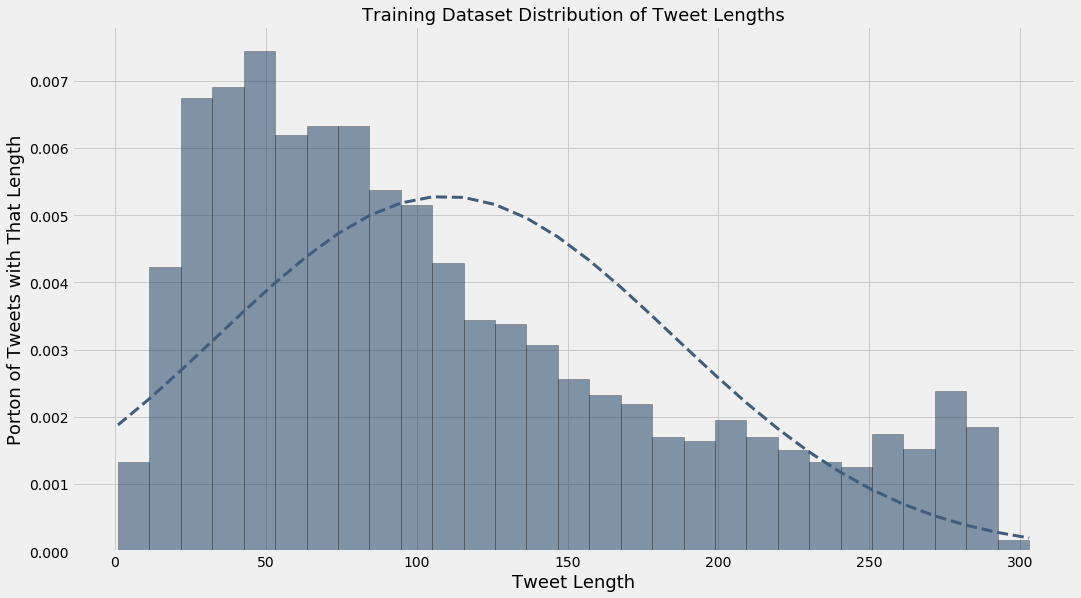

In [106]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           density=True, 
                           color="#12355b", 
                           alpha=0.5)

length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Porton of Tweets with That Length", fontsize=18);

plt.show()

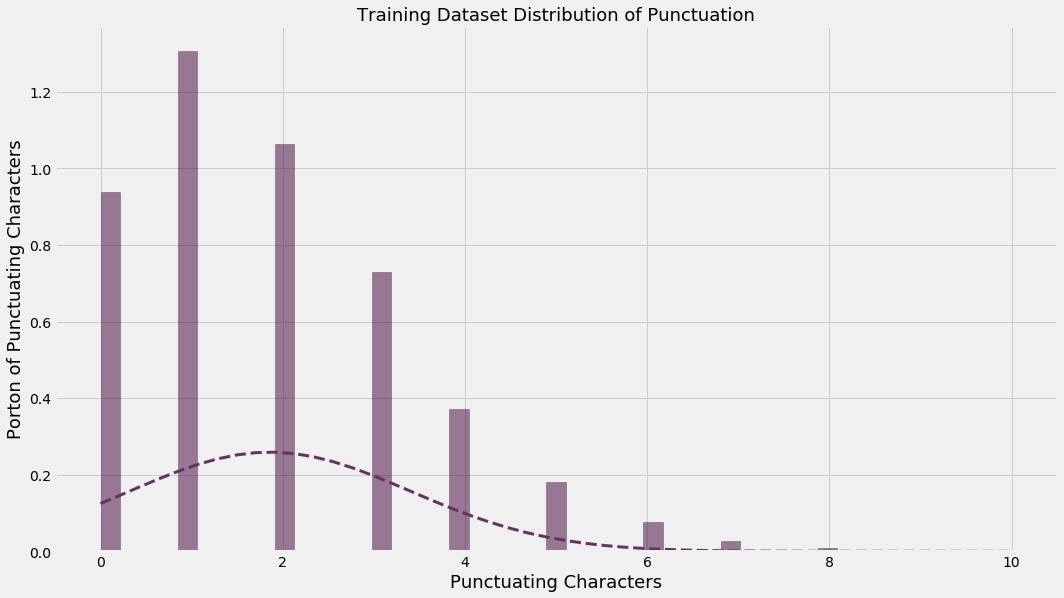

In [107]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott", 
                           edgecolor="black", 
                           density=True, 
                           color="#420039",
                           alpha=0.5)

punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters", fontsize=18)
ax.set_ylabel("Porton of Punctuating Characters", fontsize=18)

plt.show()

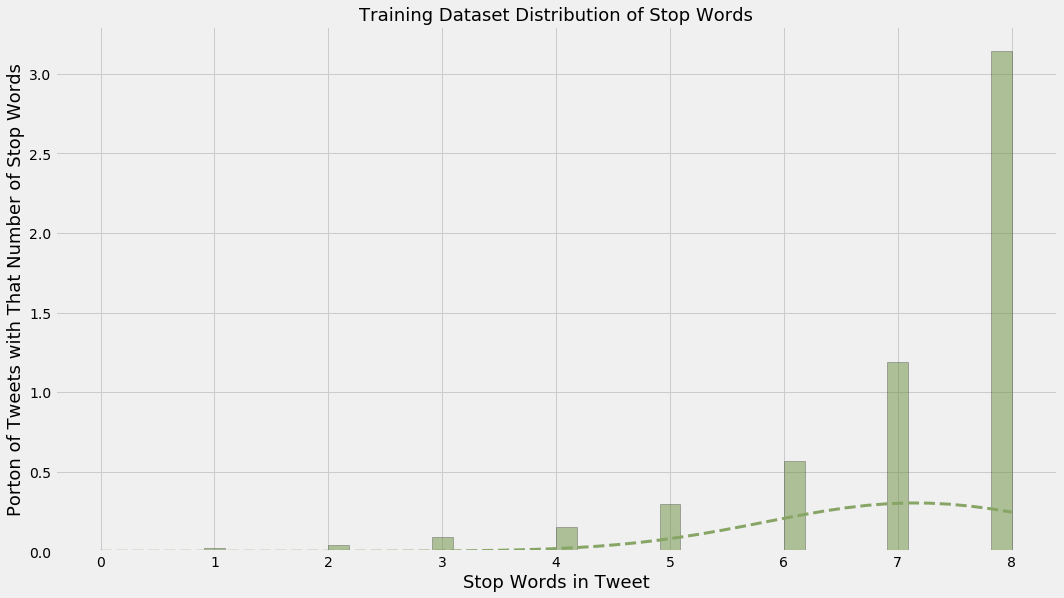

In [108]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           density=True, 
                           color="#698f3f",
                           alpha=0.5)

stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Porton of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

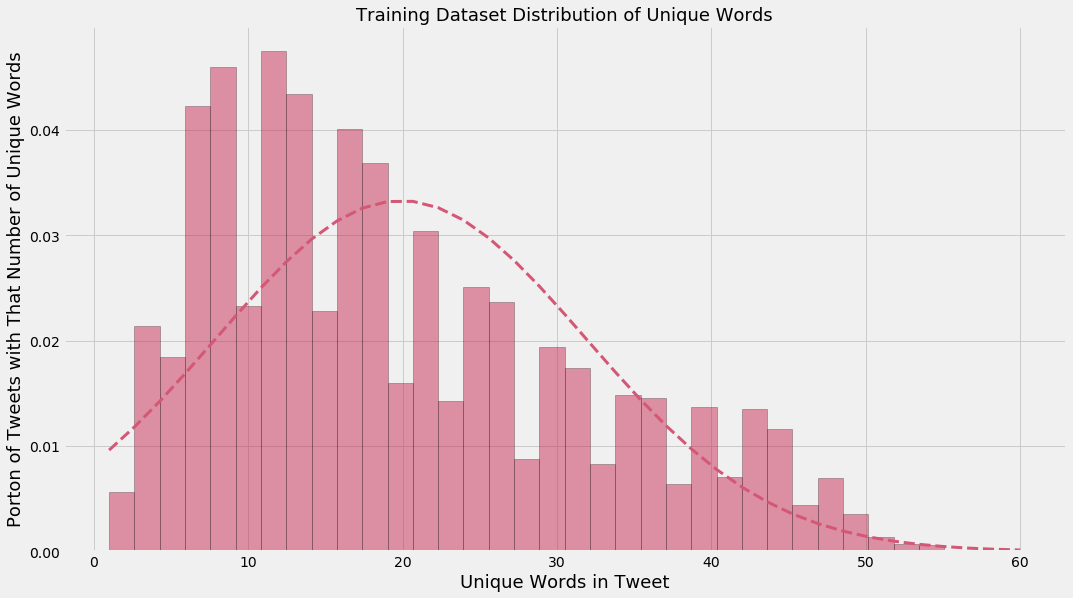

In [109]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           density=True, 
                           color="#Ca2e55",
                           alpha=0.5)

unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Porton of Tweets with That Number of Unique Words", fontsize=18)

plt.show()